# Section 4.4 : WEIGHT DECAY
## Summary
- Weight decay (WD) is another common form of regularisation, which must be balanced according to the dataset and other forms of regularisation being used
- The value should be kept constant during training; cycling is not useful
- Recommends to set WD using a gridsearch over a few WD values using CLR and CM, and compare performance over a few initial epochs of training as differences should be visible in validation loss
- "Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and deeper architectures seem to require smaller values. Our hypothesis is that complex data provides its own regularization and other regularization should be reduced." 

## Side note: weight decay versus $L_2$ regulraisation
N.B. Based on [this](http://www.fast.ai/2018/07/02/adam-weight-decay/) article.

$L_2$ is a penality term added to help prevent overfitting during training by adding to the loss the product of the $L_2$ coefficiant and the sum of squares of network weights:

$\mathrm{new\ loss} = \mathrm{loss} + \frac{L_2}{2}\sum\bar{w}^2$

Weight decay is another penalty term in which the product of the weight, the learning rate, and the weightdecay coefficiant is subtracted from the weights during update:

$\mathrm{new}\ w = w - LR*\nabla w-LR*WD*w$

In the case of vanilla SGD, these equations are equivalant and most libraries (such as Keras) only implement $L_2$ regularisation. However, once momentum or adaptive leanring-rates are added to the optimiser, weight decay is no longer equal to $L_2$. This eventually has some consequences ([especially for ADAM](https://arxiv.org/abs/1711.05101)), but since we are only dealing with SGD+momentum here, we'll instead optimise $L_2$ even though the paper specifically mentions weight decay.

## $L_2$ optimisation Example
Let's take the same model and train a few different configurations of $L_2$.
Our investigations in Section 4.3 showed that the best setup for learning rate and momentum was to use a cyclical learning rate in the range 50-500, and a constant momentum of 0.99. Based on the paper we'll run through a range of $L_2$ values for half the learning rate cycle (i.e from 50-500 without coming back to 50). Well also monitor the validation loss after every minibatch to get a more accurate picture of how the leaning rate, momentum, and $L_2$ values interact during training.

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data, features = importData()

Training on 250000 datapoints with 31 features:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [3]:
preprocParams = {'normIn':True, 'pca':False}
trainIndeces, valIndeces = train_test_split([i for i in data.index.tolist()], test_size=0.2)
train, val = foldPrep(data.iloc[trainIndeces], data.iloc[valIndeces], features, preprocParams)

In [4]:
stepScale = 4
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'sgd', 'depth':3, 'width':128, 'lr':5e2, 'momentum':0.99, 'metrics':['acc']}
trainParams = {'epochs':stepScale, 'batch_size':256, 'verbose':0}
useCallbacks={'LinearCLR':{'maxLR':5e2,'minLR':5e1, 'scale':stepScale, 'plotLR':False},
              'ValidationMonitor':{'valData':val, 'valBatchSize':trainParams['batch_size']}}

In [5]:
_, _, callbacks_0 = trainClassifier(getModel(**{'version':'modelRelu', 'nIn':len(features),
                                                'compileArgs':compileArgs}),
                                    train, val, trainParams, useEarlyStop=False, saveBest=False,
                                    useCallbacks=useCallbacks)

From the equations in the side note, we can see that the value the $L_2$ coefficient should be scaled relative to the loss. The paper recommends initially testing $L_2$ values of 0, 1e-3, 1e-4, and 1e-5, however their typical loss values are around 1. Since we are weighting our loss using samples weights which are being renormalised to account for the amount of training data we have, we need to make sure that the $L_2$ values are equally rescaled. We no that that typically, our networks start at losses of the order 1e-5 and the decrease to around 1e-6, so let's rescale $L_2$ to by 1e-5 and work from there.

In [6]:
l2Scale = 1e-5

In [7]:
_, _, callbacks_1_3 = trainClassifier(getModel(**{'version':'modelRelu', 'nIn':len(features),
                                                'compileArgs':{**compileArgs, 'l2':l2Scale*1e-3}}),
                                    train, val, trainParams, useEarlyStop=False, saveBest=False,
                                    useCallbacks=useCallbacks)

In [8]:
_, _, callbacks_1_4 = trainClassifier(getModel(**{'version':'modelRelu', 'nIn':len(features),
                                                'compileArgs':{**compileArgs, 'l2':l2Scale*1e-4}}),
                                    train, val, trainParams, useEarlyStop=False, saveBest=False,
                                    useCallbacks=useCallbacks)

In [9]:
_, _, callbacks_1_5 = trainClassifier(getModel(**{'version':'modelRelu', 'nIn':len(features),
                                                'compileArgs':{**compileArgs, 'l2':l2Scale*1e-5}}),
                                    train, val, trainParams, useEarlyStop=False, saveBest=False,
                                    useCallbacks=useCallbacks)

In [12]:
def getMonitorComparisonPlot(monitors, names, xAxis='iter', yAxis='Loss', lrLogX=True, logY=True):
    plt.figure(figsize=(16,8))
    for monitor, name in zip(monitors, names):
        if isinstance(monitor.history['val_loss'][0], list):
            if yAxis == 'Loss':
                y = np.array(monitor.history['val_loss'])[:,0]
            else:
                y = np.array(monitor.history['val_loss'])[:,1]
        else:
            y = monitor.history['val_loss']
                
        if xAxis == 'iter':
            plt.plot(range(len(monitor.history['val_loss'])), y, label=name)
        elif xAxis == 'mom':
            plt.plot(monitor.history['mom'], y, label=name)
        else:
            plt.plot(monitor.history['lr'], y, label=name)

    plt.legend(loc='best', fontsize=16)
    if lrLogX: plt.xscale('log')
    if logY: plt.yscale('log')
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    if xAxis == 'iter':
        plt.xlabel("Iteration", fontsize=24, color='black')
    elif xAxis == 'mom':
        plt.xlabel("Momentum", fontsize=24, color='black')
    else:
        plt.xlabel("Learning rate", fontsize=24, color='black')
    plt.ylabel(yAxis, fontsize=24, color='black')
    plt.show()

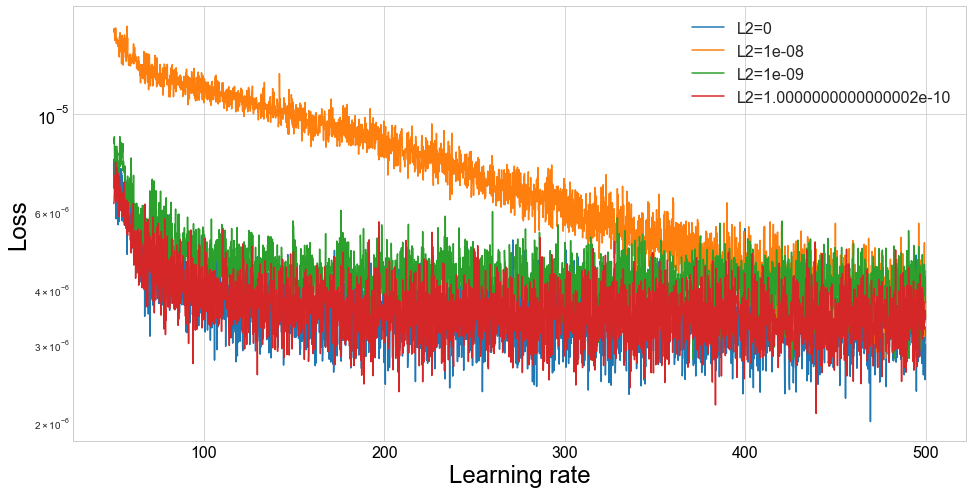

In [13]:
getMonitorComparisonPlot([callbacks_0[-1], callbacks_1_3[-1], callbacks_1_4[-1], callbacks_1_5[-1]], 
                         ['L2=0', 'L2={}'.format(l2Scale*1e-3), 'L2={}'.format(l2Scale*1e-4), 'L2={}'.format(l2Scale*1e-5)],
                         xAxis='lr', lrLogX=False, logY=True)

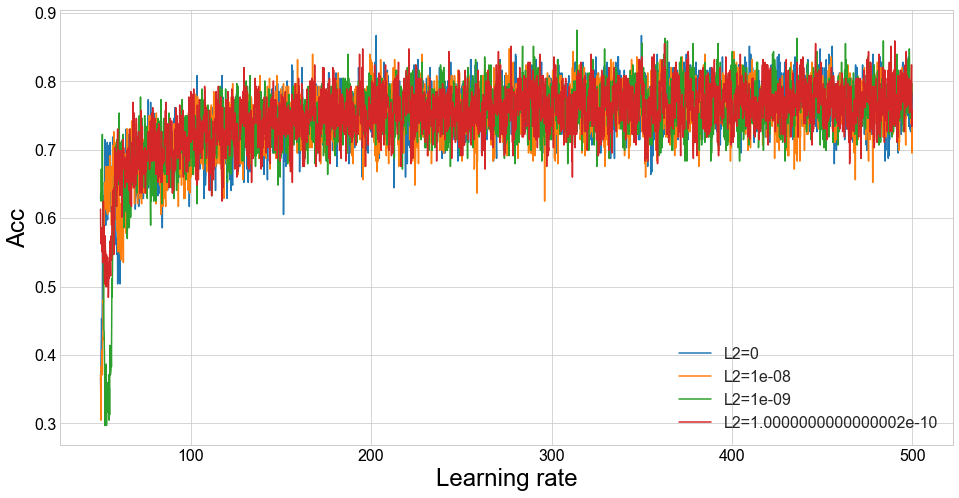

In [15]:
getMonitorComparisonPlot([callbacks_0[-1], callbacks_1_3[-1], callbacks_1_4[-1], callbacks_1_5[-1]], 
                         ['L2=0', 'L2={}'.format(l2Scale*1e-3), 'L2={}'.format(l2Scale*1e-4), 'L2={}'.format(l2Scale*1e-5)],
                         xAxis='lr', yAxis='Acc', lrLogX=False, logY=False)

From this we can see that although by the end of the learning rate cycle, all four $L_2$ setups converge to about the same point, the architecture, data, learning rate, and momentum we've chosen generally favours lower values for $L_2$, and even at $L_2=$1e-10 (<span style="color:red">red</span>), the network without $L_2$ (<span style="color:blue">blue</span>) still provides a slightly better loss, therefore it is probably safe to assume that $L_2$ regularisation can safely be switched off for this setup.